In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_9 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_17 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0767 - acc: 0.2390
Epoch 00001: val_loss improved from inf to 1.98848, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_4_conv_checkpoint/001-1.9885.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 3.0766 - acc: 0.2390 - val_loss: 1.9885 - val_acc: 0.3818
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0853 - acc: 0.3955
Epoch 00002: val_loss improved from 1.98848 to 1.40208, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_4_conv_checkpoint/002-1.4021.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 2.0853 - acc: 0.3955 - val_loss: 1.4021 - val_acc: 0.5590
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7527 - acc: 0.4686
Epoch 00003: val_loss improve

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6833 - acc: 0.7799
Epoch 00027: val_loss did not improve from 0.94350
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.6834 - acc: 0.7799 - val_loss: 1.1051 - val_acc: 0.6620
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6674 - acc: 0.7851
Epoch 00028: val_loss did not improve from 0.94350
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.6674 - acc: 0.7851 - val_loss: 1.3706 - val_acc: 0.6159
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6603 - acc: 0.7877
Epoch 00029: val_loss did not improve from 0.94350
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.6603 - acc: 0.7877 - val_loss: 1.0638 - val_acc: 0.6886
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6469 - acc: 0.7909
Epoch 00030: val_loss did not improve from 0.94350
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4938 - acc: 0.8383
Epoch 00056: val_loss did not improve from 0.87342
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.4937 - acc: 0.8383 - val_loss: 1.1775 - val_acc: 0.6820
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4919 - acc: 0.8376
Epoch 00057: val_loss did not improve from 0.87342
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.4919 - acc: 0.8375 - val_loss: 0.8958 - val_acc: 0.7505
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4893 - acc: 0.8398
Epoch 00058: val_loss did not improve from 0.87342
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.4893 - acc: 0.8398 - val_loss: 0.9591 - val_acc: 0.7365
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4904 - acc: 0.8399
Epoch 00059: val_loss did not improve from 0.87342
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4181 - acc: 0.8603
Epoch 00086: val_loss did not improve from 0.87342
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.4183 - acc: 0.8603 - val_loss: 1.0507 - val_acc: 0.7282
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4192 - acc: 0.8613
Epoch 00087: val_loss did not improve from 0.87342
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.4195 - acc: 0.8612 - val_loss: 0.9005 - val_acc: 0.7619
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4169 - acc: 0.8610
Epoch 00088: val_loss did not improve from 0.87342
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.4171 - acc: 0.8609 - val_loss: 0.9169 - val_acc: 0.7519
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4153 - acc: 0.8619
Epoch 00089: val_loss did not improve from 0.87342
36805/36805 [===========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3830 - acc: 0.8723
Epoch 00115: val_loss did not improve from 0.86439
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3830 - acc: 0.8722 - val_loss: 1.1269 - val_acc: 0.7184
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3820 - acc: 0.8738
Epoch 00116: val_loss did not improve from 0.86439
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3820 - acc: 0.8738 - val_loss: 1.1721 - val_acc: 0.7077
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3733 - acc: 0.8759
Epoch 00117: val_loss did not improve from 0.86439
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.3733 - acc: 0.8759 - val_loss: 1.0397 - val_acc: 0.7410
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8737
Epoch 00118: val_loss did not improve from 0.86439
36805/36805 [=======

Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3586 - acc: 0.8822
Epoch 00144: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3586 - acc: 0.8822 - val_loss: 0.8620 - val_acc: 0.7831
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3436 - acc: 0.8858
Epoch 00145: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3436 - acc: 0.8858 - val_loss: 0.9112 - val_acc: 0.7668
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3579 - acc: 0.8796
Epoch 00146: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3579 - acc: 0.8796 - val_loss: 0.9026 - val_acc: 0.7782
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3482 - acc: 0.8840
Epoch 00147: val_loss did not improve from 0.84696
36805/36805 [=======

Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8884
Epoch 00174: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3360 - acc: 0.8884 - val_loss: 0.8927 - val_acc: 0.7759
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3311 - acc: 0.8893
Epoch 00175: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3311 - acc: 0.8893 - val_loss: 1.0065 - val_acc: 0.7512
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3300 - acc: 0.8904
Epoch 00176: val_loss did not improve from 0.84696
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.3300 - acc: 0.8904 - val_loss: 0.9812 - val_acc: 0.7529

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_4_conv Model


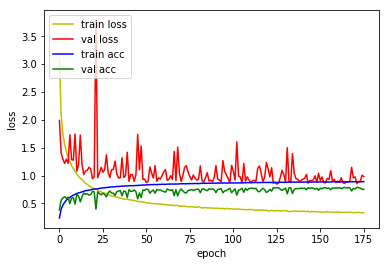

4815/4815 [==============================] - 4s 767us/sample - loss: 0.9613 - acc: 0.7362
Loss: 0.9613271430769195 Accuracy: 0.7362409

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1851 - acc: 0.2320
Epoch 00001: val_loss improved from inf to 1.84292, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_5_conv_checkpoint/001-1.8429.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 3.1854 - acc: 0.2320 - val_loss: 1.8429 - val_acc: 0.4086
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2065 - acc: 0.3862
Epoch 00002: val_loss improved from 1.84292 to 1.69928, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_5_conv_checkpoint/002-1.6993.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 2.2065 - acc: 0.3862 - val_loss: 1.6993 - val_acc: 0.4801
Epoch 3/500
36800/36805 [============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7438 - acc: 0.7681
Epoch 00024: val_loss did not improve from 0.80945
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.7437 - acc: 0.7681 - val_loss: 1.1652 - val_acc: 0.6529
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7332 - acc: 0.7705
Epoch 00025: val_loss did not improve from 0.80945
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.7333 - acc: 0.7705 - val_loss: 0.8137 - val_acc: 0.7633
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7315 - acc: 0.7698
Epoch 00026: val_loss did not improve from 0.80945
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.7317 - acc: 0.7698 - val_loss: 0.8832 - val_acc: 0.7393
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7010 - acc: 0.7812
Epoch 00027: val_loss did not improve from 0.80945
36805/36805 [===========

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5277 - acc: 0.8288
Epoch 00052: val_loss did not improve from 0.74635
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.5276 - acc: 0.8289 - val_loss: 0.7853 - val_acc: 0.7794
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5218 - acc: 0.8327
Epoch 00053: val_loss did not improve from 0.74635
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.5219 - acc: 0.8326 - val_loss: 0.7715 - val_acc: 0.7885
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5240 - acc: 0.8329
Epoch 00054: val_loss did not improve from 0.74635
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.5240 - acc: 0.8329 - val_loss: 0.7815 - val_acc: 0.7796
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5041 - acc: 0.8370
Epoch 00055: val_loss did not improve from 0.74635
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.4359 - acc: 0.8568
Epoch 00081: val_loss did not improve from 0.73006
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.4359 - acc: 0.8568 - val_loss: 0.7389 - val_acc: 0.8013
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4304 - acc: 0.8592
Epoch 00082: val_loss did not improve from 0.73006
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.4305 - acc: 0.8591 - val_loss: 0.7858 - val_acc: 0.7876
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4303 - acc: 0.8573
Epoch 00083: val_loss did not improve from 0.73006
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.4303 - acc: 0.8574 - val_loss: 0.7979 - val_acc: 0.7827
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4312 - acc: 0.8606
Epoch 00084: val_loss did not improve from 0.73006
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3832 - acc: 0.8726
Epoch 00110: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3835 - acc: 0.8725 - val_loss: 0.7390 - val_acc: 0.8043
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3848 - acc: 0.8729
Epoch 00111: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3848 - acc: 0.8730 - val_loss: 0.7480 - val_acc: 0.8043
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3690 - acc: 0.8763
Epoch 00112: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3689 - acc: 0.8763 - val_loss: 0.8011 - val_acc: 0.7883
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3783 - acc: 0.8745
Epoch 00113: val_loss did not improve from 0.71562
36805/36805 [=====================

Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8849
Epoch 00140: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3491 - acc: 0.8849 - val_loss: 0.7887 - val_acc: 0.7985
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3501 - acc: 0.8833
Epoch 00141: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3501 - acc: 0.8833 - val_loss: 0.8124 - val_acc: 0.7934
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8846
Epoch 00142: val_loss did not improve from 0.71562
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.3492 - acc: 0.8846 - val_loss: 0.7681 - val_acc: 0.8046
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3448 - acc: 0.8865
Epoch 00143: val_loss did not improve from 0.71562
36805/36805 [=======

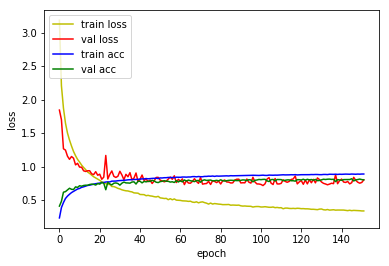

4815/4815 [==============================] - 4s 827us/sample - loss: 0.7974 - acc: 0.7861
Loss: 0.7974302536973329 Accuracy: 0.7860851

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3064 - acc: 0.1971
Epoch 00001: val_loss improved from inf to 2.19655, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_6_conv_checkpoint/001-2.1965.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 3.3063 - acc: 0.1971 - val_loss: 2.1965 - val_acc: 0.3019
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3237 - acc: 0.3376
Epoch 00002: val_loss improved from 2.19655 to 1.53590, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_6_conv_checkpoint/002-1.5359.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 2.3237 - acc: 0.3376 - val_loss: 1.5359 - val_acc: 0.5302
Epoch 3/500
36800/36805 [============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7820 - acc: 0.7618
Epoch 00024: val_loss improved from 0.75078 to 0.73736, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_6_conv_checkpoint/024-0.7374.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.7823 - acc: 0.7617 - val_loss: 0.7374 - val_acc: 0.7815
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7681 - acc: 0.7633
Epoch 00025: val_loss did not improve from 0.73736
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.7682 - acc: 0.7632 - val_loss: 0.7880 - val_acc: 0.7610
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7568 - acc: 0.7671
Epoch 00026: val_loss improved from 0.73736 to 0.72961, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_6_conv_checkpoint/026-0.7296.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.8144
Epoch 00051: val_loss did not improve from 0.63102
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.5921 - acc: 0.8144 - val_loss: 0.6881 - val_acc: 0.7943
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5795 - acc: 0.8175
Epoch 00052: val_loss did not improve from 0.63102
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.5795 - acc: 0.8174 - val_loss: 0.6609 - val_acc: 0.8099
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5790 - acc: 0.8218
Epoch 00053: val_loss did not improve from 0.63102
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.5789 - acc: 0.8218 - val_loss: 0.6985 - val_acc: 0.7990
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5721 - acc: 0.8219
Epoch 00054: val_loss did not improve from 0.63102
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4983 - acc: 0.8432
Epoch 00080: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4984 - acc: 0.8432 - val_loss: 0.6998 - val_acc: 0.8032
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4948 - acc: 0.8432
Epoch 00081: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4947 - acc: 0.8433 - val_loss: 0.6641 - val_acc: 0.8164
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4961 - acc: 0.8421
Epoch 00082: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4961 - acc: 0.8421 - val_loss: 0.6840 - val_acc: 0.8062
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4909 - acc: 0.8428
Epoch 00083: val_loss did not improve from 0.60850
36805/36805 [===========

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4379 - acc: 0.8610
Epoch 00110: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4378 - acc: 0.8610 - val_loss: 0.6386 - val_acc: 0.8237
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4338 - acc: 0.8617
Epoch 00111: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4339 - acc: 0.8617 - val_loss: 0.7629 - val_acc: 0.7894
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4407 - acc: 0.8585
Epoch 00112: val_loss did not improve from 0.60850
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.4408 - acc: 0.8584 - val_loss: 0.6401 - val_acc: 0.8279
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4329 - acc: 0.8608
Epoch 00113: val_loss did not improve from 0.60850
36805/36805 [=======

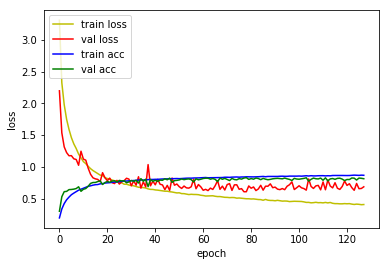

4815/4815 [==============================] - 4s 905us/sample - loss: 0.7005 - acc: 0.7952
Loss: 0.7004882454376974 Accuracy: 0.79522324

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.4200 - acc: 0.1475
Epoch 00001: val_loss improved from inf to 2.30190, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_7_conv_checkpoint/001-2.3019.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 3.4201 - acc: 0.1475 - val_loss: 2.3019 - val_acc: 0.2972
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5483 - acc: 0.2719
Epoch 00002: val_loss improved from 2.30190 to 1.74669, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_7_conv_checkpoint/002-1.7467.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 2.5483 - acc: 0.2719 - val_loss: 1.7467 - val_acc: 0.4645
Epoch 3/500
36800/36805 [==========

36800/36805 [============================>.] - ETA: 0s - loss: 0.7992 - acc: 0.7537
Epoch 00024: val_loss did not improve from 0.73558
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.7993 - acc: 0.7536 - val_loss: 0.7617 - val_acc: 0.7778
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7868 - acc: 0.7602
Epoch 00025: val_loss did not improve from 0.73558
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.7867 - acc: 0.7603 - val_loss: 0.7854 - val_acc: 0.7724
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7713 - acc: 0.7654
Epoch 00026: val_loss did not improve from 0.73558
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.7713 - acc: 0.7654 - val_loss: 0.7831 - val_acc: 0.7647
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7593 - acc: 0.7688
Epoch 00027: val_loss improved from 0.73558 to 0.73227, saving model to model/checkpoint

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5738 - acc: 0.8233
Epoch 00051: val_loss did not improve from 0.59449
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5738 - acc: 0.8233 - val_loss: 0.6186 - val_acc: 0.8162
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5702 - acc: 0.8245
Epoch 00052: val_loss did not improve from 0.59449
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5703 - acc: 0.8244 - val_loss: 0.6509 - val_acc: 0.7999
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5714 - acc: 0.8246
Epoch 00053: val_loss did not improve from 0.59449
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.5713 - acc: 0.8246 - val_loss: 0.5968 - val_acc: 0.8307
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5610 - acc: 0.8273
Epoch 00054: val_loss did not improve from 0.59449
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4550 - acc: 0.8583
Epoch 00080: val_loss did not improve from 0.55738
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.4552 - acc: 0.8583 - val_loss: 0.6265 - val_acc: 0.8251
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4612 - acc: 0.8562
Epoch 00081: val_loss did not improve from 0.55738
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.4612 - acc: 0.8562 - val_loss: 0.6330 - val_acc: 0.8274
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4596 - acc: 0.8559
Epoch 00082: val_loss did not improve from 0.55738
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.4596 - acc: 0.8559 - val_loss: 0.5977 - val_acc: 0.8286
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4496 - acc: 0.8556
Epoch 00083: val_loss did not improve from 0.55738
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.3812 - acc: 0.8753
Epoch 00109: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3814 - acc: 0.8753 - val_loss: 0.6300 - val_acc: 0.8288
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3774 - acc: 0.8792
Epoch 00110: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3774 - acc: 0.8792 - val_loss: 0.5854 - val_acc: 0.8369
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8792
Epoch 00111: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3765 - acc: 0.8792 - val_loss: 0.5852 - val_acc: 0.8355
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3720 - acc: 0.8810
Epoch 00112: val_loss did not improve from 0.55227
36805/36805 [=====================

Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3218 - acc: 0.8949
Epoch 00139: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3218 - acc: 0.8949 - val_loss: 0.6041 - val_acc: 0.8437
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8952
Epoch 00140: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3232 - acc: 0.8952 - val_loss: 0.6543 - val_acc: 0.8255
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3175 - acc: 0.8970
Epoch 00141: val_loss did not improve from 0.55227
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.3177 - acc: 0.8969 - val_loss: 0.6395 - val_acc: 0.8328
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.8945
Epoch 00142: val_loss did not improve from 0.55227
36805/36805 [=======

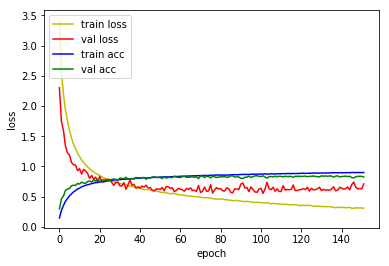

4815/4815 [==============================] - 5s 954us/sample - loss: 0.6379 - acc: 0.8222
Loss: 0.6378942030674448 Accuracy: 0.82222223

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5043 - acc: 0.1391
Epoch 00001: val_loss improved from inf to 2.31339, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_8_conv_checkpoint/001-2.3134.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 3.5042 - acc: 0.1391 - val_loss: 2.3134 - val_acc: 0.2828
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6239 - acc: 0.2370
Epoch 00002: val_loss improved from 2.31339 to 1.80423, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_8_conv_checkpoint/002-1.8042.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.6238 - acc: 0.2370 - val_loss: 1.8042 - val_acc: 0.4689
Epoch 3/500
36800/36805 [==========

36800/36805 [============================>.] - ETA: 0s - loss: 0.6139 - acc: 0.8109
Epoch 00023: val_loss did not improve from 0.48380
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.6139 - acc: 0.8109 - val_loss: 0.5081 - val_acc: 0.8523
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5918 - acc: 0.8177
Epoch 00024: val_loss did not improve from 0.48380
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5919 - acc: 0.8176 - val_loss: 0.4852 - val_acc: 0.8670
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5829 - acc: 0.8224
Epoch 00025: val_loss improved from 0.48380 to 0.43470, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_8_conv_checkpoint/025-0.4347.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5830 - acc: 0.8224 - val_loss: 0.4347 - val_acc: 0.8765
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s -

36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3513 - acc: 0.8912 - val_loss: 0.3146 - val_acc: 0.9101
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3323 - acc: 0.8965
Epoch 00049: val_loss did not improve from 0.31464
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3328 - acc: 0.8965 - val_loss: 0.3187 - val_acc: 0.9182
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3355 - acc: 0.8946
Epoch 00050: val_loss improved from 0.31464 to 0.29905, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_8_conv_checkpoint/050-0.2991.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.3357 - acc: 0.8946 - val_loss: 0.2991 - val_acc: 0.9208
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3324 - acc: 0.8967
Epoch 00051: val_loss did not improve from 0.29905
36805/36805 [==============================] - 84s 2ms/s

36800/36805 [============================>.] - ETA: 0s - loss: 0.2344 - acc: 0.9246
Epoch 00076: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2345 - acc: 0.9246 - val_loss: 0.2879 - val_acc: 0.9201
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2406 - acc: 0.9236
Epoch 00077: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2409 - acc: 0.9236 - val_loss: 0.2990 - val_acc: 0.9201
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9221
Epoch 00078: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2383 - acc: 0.9220 - val_loss: 0.2937 - val_acc: 0.9208
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2287 - acc: 0.9257
Epoch 00079: val_loss did not improve from 0.27957
36805/36805 [========================

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1755 - acc: 0.9414
Epoch 00106: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1758 - acc: 0.9414 - val_loss: 0.3162 - val_acc: 0.9252
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1810 - acc: 0.9401
Epoch 00107: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1810 - acc: 0.9400 - val_loss: 0.3150 - val_acc: 0.9187
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1696 - acc: 0.9446
Epoch 00108: val_loss did not improve from 0.27957
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1697 - acc: 0.9446 - val_loss: 0.3105 - val_acc: 0.9147
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1701 - acc: 0.9434
Epoch 00109: val_loss did not improve from 0.27957
36805/36805 [=======

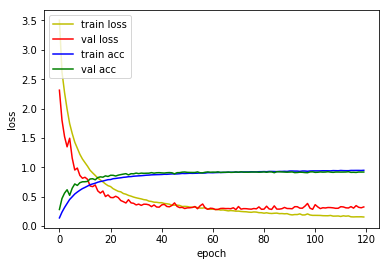

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3485 - acc: 0.9040
Loss: 0.3485432178555743 Accuracy: 0.9040499

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2364 - acc: 0.1989
Epoch 00001: val_loss improved from inf to 2.22806, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_9_conv_checkpoint/001-2.2281.hdf5
36805/36805 [==============================] - 133s 4ms/sample - loss: 3.2367 - acc: 0.1989 - val_loss: 2.2281 - val_acc: 0.2991
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1924 - acc: 0.3592
Epoch 00002: val_loss improved from 2.22806 to 1.31975, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_9_conv_checkpoint/002-1.3197.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.1926 - acc: 0.3591 - val_loss: 1.3197 - val_acc: 0.6196
Epoch 3/500
36800/36805 [=============

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2737 - acc: 0.9156
Epoch 00023: val_loss improved from 0.21142 to 0.20563, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_9_conv_checkpoint/023-0.2056.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2738 - acc: 0.9156 - val_loss: 0.2056 - val_acc: 0.9415
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2642 - acc: 0.9204
Epoch 00024: val_loss did not improve from 0.20563
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2643 - acc: 0.9204 - val_loss: 0.2077 - val_acc: 0.9394
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.9230
Epoch 00025: val_loss did not improve from 0.20563
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.2476 - acc: 0.9229 - val_loss: 0.2116 - val_acc: 0.9380
Epoch 26/500
36800/36805 [============================>.

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9572
Epoch 00050: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1329 - acc: 0.9572 - val_loss: 0.2125 - val_acc: 0.9443
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9615
Epoch 00051: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1229 - acc: 0.9615 - val_loss: 0.2220 - val_acc: 0.9376
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9623
Epoch 00052: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1176 - acc: 0.9623 - val_loss: 0.2029 - val_acc: 0.9469
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1132 - acc: 0.9642
Epoch 00053: val_loss did not improve from 0.18250
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9774
Epoch 00080: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0684 - acc: 0.9774 - val_loss: 0.2531 - val_acc: 0.9357
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9782
Epoch 00081: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0671 - acc: 0.9782 - val_loss: 0.2539 - val_acc: 0.9394
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9769
Epoch 00082: val_loss did not improve from 0.18250
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0713 - acc: 0.9769 - val_loss: 0.2421 - val_acc: 0.9418
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9785
Epoch 00083: val_loss did not improve from 0.18250
36805/36805 [===========

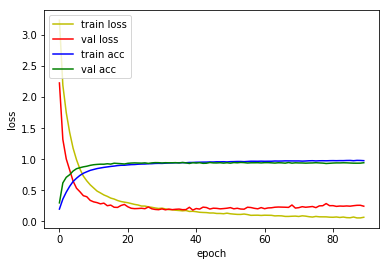

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2482 - acc: 0.9277
Loss: 0.2481907156676147 Accuracy: 0.92772585



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.7005 - acc: 0.7952
Loss: 0.7004882454376974 Accuracy: 0.79522324

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_24 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_25 (A

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3485 - acc: 0.9040
Loss: 0.3485432178555743 Accuracy: 0.9040499

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_150 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_29 (Ac

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.8034 - acc: 0.7734
Loss: 0.8034019653299516 Accuracy: 0.7734164

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_24 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_25 (Ac

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.4257 - acc: 0.8918
Loss: 0.4257411071970703 Accuracy: 0.89179647

1D_CNN_custom_conv_3_VGG_ch_32_DO_075_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_150 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_29 (A